Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


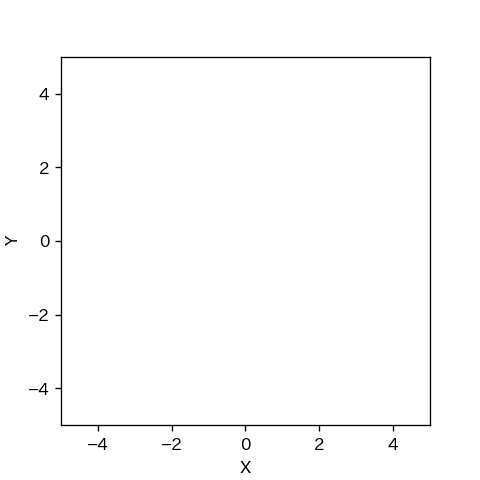

In [1]:
import sys
sys.path.append('../scripts/')
from mcl import*

In [2]:
class ResetMcl(Mcl): ###resetmcl3 （12行目以下）
    def __init__(self, envmap, init_pose, num, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}, \
                 distance_dev_rate=0.14, direction_dev=0.05, alpha_threshold=0.001): #alpha_thresholdを追加
        super().__init__(envmap, init_pose, num, motion_noise_stds, distance_dev_rate, direction_dev)
        self.alpha_threshold = alpha_threshold #追加
        
        
    def random_reset(self):
         for p in self.particles:
                p.pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
                p.weight = 1/len(self.particles)
                
    def sensor_resetting_draw(self, particle, landmark_pos, ell_obs, phi_obs): #追加
            ##パーティクルの位置を決める##
            psi = np.random.uniform(-np.pi, np.pi) #ランドマークからの方角を選ぶ
            ell = norm(loc=ell_obs, scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
            particle.pose[0] = landmark_pos[0] + ell*math.cos(psi)
            particle.pose[1] = landmark_pos[1] + ell*math.sin(psi)
            
            ##パーティクルの向きを決める##
            phi = norm(loc=phi_obs, scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
            particle.pose[2] = math.atan2(landmark_pos[1]- particle.pose[1], landmark_pos[0]- particle.pose[0]) - phi
            
            particle.weight = 1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self, observation): 
        d=list([obs[0][0] for obs in observation])
        if len(d)==2:
            nearest_obs=np.argmin([obs[0][0] for obs in observation]) #最小値の位置=最小値の位置を求める関数(idを含むセンサ値のリスト)
            values1, landmark_id1=observation[nearest_obs]#単なるセンサ値のリスト
            b = sorted(d).index(sorted(d)[1]) #ただのセンサ値
            values2, landmark_id2 = observation[b]   #bの型がおかしい可能性がある b(センサ値)の場所をobservation[]のかっこに入れる
            for p in self.particles:
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id1].pos, *values1)
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id2].pos, *values2)
                
            print(d)
            
            
        elif len(d)==1:
            nearest_obs3=np.argmin([obs[0][0] for obs in observation])
            values3, landmark_id3=observation[nearest_obs3]
            
            for p in self.particles:
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id3].pos, *values3)
                
            print(d)
                
    def observation_update(self, observation):        
        for p in self.particles:
            p.observation_update(observation, self.map, self.distance_dev_rate, self.direction_dev) 
            
        self.set_ml()

        if sum([p.weight for p in self.particles]) < self.alpha_threshold:
            self.sensor_resetting(observation) 
        else:
            self.resampling()

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [3]:
def trial_trap_phantom(animation):
    time_interval=0.1
    world=World(30,time_interval,debug=not animation)
    
    ##地図を生成して3つランドマークを追加##
    m=Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)
    
    ##ロボットを作る##
    init_pose=np.array([0,0,0]).T
    robot_pose=np.array([0,0,0]).T
    pf=ResetMcl(m,init_pose,100)
    a=EstimationAgent(time_interval,0.2,10.0/180*math.pi,pf)
    r=Robot(robot_pose,sensor=Camera(m,phantom_prob=0.1),agent=a,color="red",expected_stuck_time=5,expected_escape_time=5)
    world.append(r)
    
    world.draw()
    return(r.pose,pf.ml.pose)

<IPython.core.display.Javascript object>


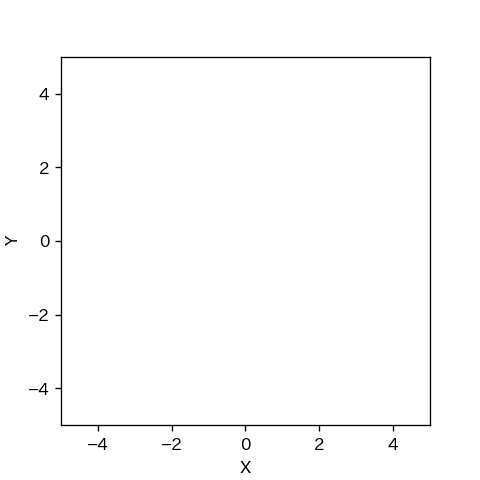

(array([0, 0, 0]), array([0, 0, 0]))

In [4]:
trial_trap_phantom(True)

In [5]:
if __name__ =='__main__':
    ok=0
    for i in range(1000):
        actual, estm=trial_trap_phantom(False)
        diff=math.sqrt((actual[0]-estm[0])**2+(actual[1]-estm[1])**2)
        print(i,"真値:",actual,"推定値:",estm,"誤差:",diff)
        if diff<=1.0:
            ok+=1
            print(ok)

[5.242106387659084]
[4.942453040786247, 5.001628558116798]
[5.108249983064448]
[4.892906847271917]
[5.009612805793354, 4.481519010870733]
[4.4558556435474745]
[4.462250248736042]
[5.004876348374287, 4.45700049627133]
[5.530149198948426, 5.193963325252485]
[4.234800013028437]
[5.268928938450598]
[4.604747273774716]
[3.004797063861995, 5.756546209607695]
[6.075743106020636, 3.7522018848258045]
[5.071001838274808]
[4.38416412108172]
[4.913568828573955]
[4.731533982235636]
[4.2911281959801, 4.133961044414871]
[5.791670064641593]
[5.058472412414911]
[3.3929685553521374, 4.459265569935399]
[3.3616866315026566]
[4.5480982829070795]
[3.4934271164971142, 4.541487153308659]
[4.782133510668211, 3.7667473809488192]
[1.1796667541505126]
[2.2565400317465274, 4.7510187361038]
[3.6319909298954025, 5.374832640357267]
[4.736193253190438, 4.828842261012485]
[5.15074982103631]
[4.4210559486322945]
[4.975251011243303, 3.8998673711594685]
[4.691381282368198, 4.381787972530707]
[5.6121209467122934, 4.2821341

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


[4.117965998299262, 4.714042051783967]
[4.398475587236243]
[4.18968042046023]
[4.798551934329274]
[3.710366418252313]
[3.3161731457849557, 3.4095576276411057]
[3.788361436967776]
[3.2130673830198595]
[4.267019186565319, 3.6860155763061746]
[4.923459612441204]
[4.457175669055167, 0.9285556433744876]
[4.39188324219253]
[5.1305165205457]
[4.67381311503168]
[2.1106428056182516]
[4.950248202980504]
[4.207119384910083, 3.0058664028352524]
[4.386942574419426, 4.428528313833699]
[4.74479623372685]
[2.470261106533917]
[4.64822122421979, 4.096399245901251]
[4.637983063037718]
[0.7556124907208107]
[4.450237333979914]
[4.643897667800549]
[4.415774757970674]
[4.600150544003194, 5.4887248804045035]
[4.907470873891879]
20 真値: [0.36088281 1.77392944 2.5299764 ] 推定値: [-6.42466139 -1.46884733  0.4977102 ] 誤差: 7.520585831555586
[4.350017471123591]
[3.586203575491737]
[2.7379977005048968, 3.027439261752834]
[2.439307855950926]
[1.6282809515804932]
[4.0273981374215895, 1.8239922850099262]
[5.67518189242575